In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

Since XGBoost uses DecisionTree in its algorithm, it does not require normalizaiton

In [2]:
df=pd.read_csv(r"../data/cardio_train.csv",  delimiter=';')
df.drop(['id'], axis = 1, inplace=True)
df['age'] = [int(age/365) for age in df['age']]

In [3]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,52.840671,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.766774,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,29.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
x = df[features]
y = df['cardio']

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [6]:
n_estimators = [1, 2, 4, 8, 16, 32, 64]
train_results = []
test_results = []

In [7]:
for estimator in n_estimators:
    rf = XGBClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

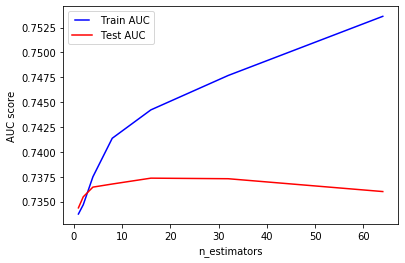

In [8]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.savefig('XGBoost best n_estimators.png', dpi=150)
plt.show()

In [9]:
max_depth = [1, 2, 4, 8, 16]
train_results = []
test_results = []

In [10]:
for depth in max_depth:
    rf = XGBClassifier(max_depth=depth, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

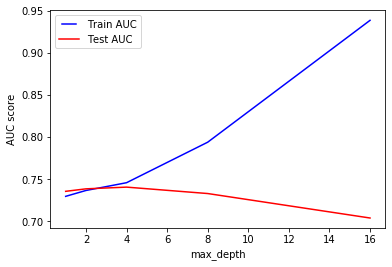

In [11]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depth, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depth, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.savefig('XGBoost best max_depth.png', dpi=150)
plt.show()

In [12]:
xgb_model = XGBClassifier()

In [13]:
parameters = {'n_estimators':[5],'max_depth':[6],'objective': ['binary:logistic','reg:logistic','count:poisson','rank:pairwise'],'random_state':[42]}

gridsearchmodel = GridSearchCV(xgb_model, parameters,cv=3,verbose=2, n_jobs=-1)
gridsearchmodel.fit(x_train, y_train)
y_pred = gridsearchmodel.predict(x_test)
print(accuracy_score(y_pred,y_test))

gridsearchmodel.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    6.6s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.4s finished


0.7367142857142858


{'max_depth': 6,
 'n_estimators': 5,
 'objective': 'binary:logistic',
 'random_state': 42}

In [14]:
parameters = {'n_estimators':[10],'max_depth':[6],'objective': ['binary:logistic','reg:logistic','count:poisson','rank:pairwise'],'random_state':[42]}

gridsearchmodel = GridSearchCV(xgb_model, parameters,cv=3,verbose=2, n_jobs=-1)
gridsearchmodel.fit(x_train, y_train)
y_pred = gridsearchmodel.predict(x_test)
print(accuracy_score(y_pred,y_test))

gridsearchmodel.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    1.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.4s finished


0.7373333333333333


{'max_depth': 6,
 'n_estimators': 10,
 'objective': 'binary:logistic',
 'random_state': 42}

In [15]:
parameters = {'n_estimators':[15],'max_depth':[6],'objective': ['binary:logistic','reg:logistic','count:poisson','rank:pairwise'],'random_state':[42]}

gridsearchmodel = GridSearchCV(xgb_model, parameters,cv=3,verbose=2, n_jobs=-1)
gridsearchmodel.fit(x_train, y_train)
y_pred = gridsearchmodel.predict(x_test)
print(accuracy_score(y_pred,y_test))

gridsearchmodel.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    4.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.5s finished


0.7367619047619047


{'max_depth': 6,
 'n_estimators': 15,
 'objective': 'binary:logistic',
 'random_state': 42}

In [16]:
parameters = {'n_estimators':[20],'max_depth':[6],'objective': ['binary:logistic','reg:logistic','count:poisson','rank:pairwise'],'random_state':[42]}

gridsearchmodel = GridSearchCV(xgb_model, parameters,cv=3,verbose=2, n_jobs=-1)
gridsearchmodel.fit(x_train, y_train)
y_pred = gridsearchmodel.predict(x_test)
print(accuracy_score(y_pred,y_test))

gridsearchmodel.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    5.3s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.3s finished


0.7367619047619047


{'max_depth': 6,
 'n_estimators': 20,
 'objective': 'binary:logistic',
 'random_state': 42}

In [17]:
parameters = {'n_estimators':[5],'max_depth':[4],'objective': ['binary:logistic','reg:logistic','count:poisson','rank:pairwise'],'random_state':[42]}

gridsearchmodel = GridSearchCV(xgb_model, parameters,cv=3,verbose=2, n_jobs=-1)
gridsearchmodel.fit(x_train, y_train)
y_pred = gridsearchmodel.predict(x_test)
print(accuracy_score(y_pred,y_test))

gridsearchmodel.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    1.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.0s finished


0.7343333333333333


{'max_depth': 4,
 'n_estimators': 5,
 'objective': 'binary:logistic',
 'random_state': 42}

In [18]:
parameters = {'n_estimators':[10],'max_depth':[4],'objective': ['binary:logistic','reg:logistic','count:poisson','rank:pairwise'],'random_state':[42]}

gridsearchmodel = GridSearchCV(xgb_model, parameters,cv=3,verbose=2, n_jobs=-1)
gridsearchmodel.fit(x_train, y_train)
y_pred = gridsearchmodel.predict(x_test)
print(accuracy_score(y_pred,y_test))

gridsearchmodel.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    2.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.3s finished


0.7378571428571429


{'max_depth': 4,
 'n_estimators': 10,
 'objective': 'binary:logistic',
 'random_state': 42}

In [19]:
parameters = {'n_estimators':[15],'max_depth':[4],'objective': ['binary:logistic','reg:logistic','count:poisson','rank:pairwise'],'random_state':[42]}

gridsearchmodel = GridSearchCV(xgb_model, parameters,cv=3,verbose=2, n_jobs=-1)
gridsearchmodel.fit(x_train, y_train)
y_pred = gridsearchmodel.predict(x_test)
print(accuracy_score(y_pred,y_test))

gridsearchmodel.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    2.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.4s finished


0.7398571428571429


{'max_depth': 4,
 'n_estimators': 15,
 'objective': 'binary:logistic',
 'random_state': 42}

In [20]:
parameters = {'n_estimators':[20],'max_depth':[4],'objective': ['binary:logistic','reg:logistic','count:poisson','rank:pairwise'],'random_state':[42]}

gridsearchmodel = GridSearchCV(xgb_model, parameters,cv=3,verbose=2, n_jobs=-1)
gridsearchmodel.fit(x_train, y_train)
y_pred = gridsearchmodel.predict(x_test)
print(accuracy_score(y_pred,y_test))

gridsearchmodel.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    3.2s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.1s finished


0.7400952380952381


{'max_depth': 4,
 'n_estimators': 20,
 'objective': 'binary:logistic',
 'random_state': 42}

In [21]:
parameters = {'n_estimators':[5,10,15,20],'max_depth':[2,4,6],'objective': ['binary:logistic','reg:logistic','count:poisson','rank:pairwise'],'random_state':[42]}

gridsearchmodel = GridSearchCV(xgb_model, parameters,cv=3,verbose=2, n_jobs=-1)
gridsearchmodel.fit(x_train, y_train)

y_pred = gridsearchmodel.predict(x_test)
print(accuracy_score(y_pred,y_test))

gridsearchmodel.best_params_



Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   33.8s finished


0.7400952380952381


{'max_depth': 4,
 'n_estimators': 20,
 'objective': 'binary:logistic',
 'random_state': 42}

In [22]:
xgb_model = XGBClassifier(max_depth = 6, n_estimators = 20, objective = 'rank:pairwise')
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=0, num_parallel_tree=1,
              objective='rank:pairwise', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

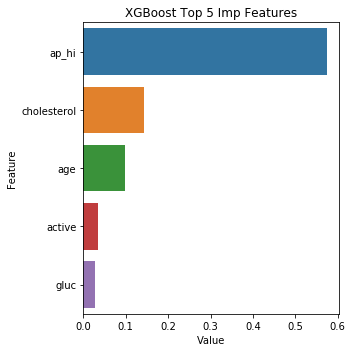

In [23]:
feature_imp = pd.DataFrame(sorted(zip(xgb_model.feature_importances_,x.columns)), columns=['Value','Feature'])
feature_imp_top_10 = feature_imp.sort_values(by = 'Value',ascending=False).reset_index(drop=True)[:5]
plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp_top_10)
plt.title('XGBoost Top 5 Imp Features')
plt.tight_layout()
plt.savefig('XGBoost important features', dpi=150)
plt.show()

In [24]:
y_pred_prob = xgb_model.predict_proba(x_test)[:, 1]

<Figure size 432x288 with 0 Axes>

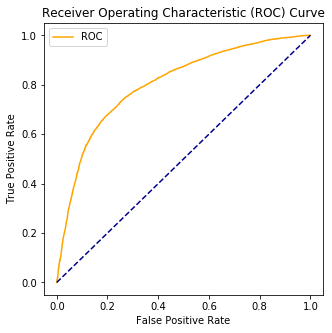

In [25]:
plt.figure(0).clf()
plt.figure(figsize=(5, 5))
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.savefig('XGBoost ROC', dpi=150)
plt.legend(loc=0)

In [26]:
confusion_matrix(y_test, y_pred)

array([[8208, 2253],
       [3205, 7334]])